# Autoencoder for NSL-KDD (Anomaly Detection)

This notebook implements an **Autoencoder** for anomaly-based Intrusion Detection on the NSL-KDD dataset.

**Key Approach:**
- **Training**: The model is trained **ONLY on Normal traffic** to learn the latent representation of legitimate behavior.
- **Detection**: Attacks are detected as anomalies when the **reconstruction error** exceeds a threshold.
- **Advantage**: Can detect novel/unknown attacks (zero-day exploits) that differ from normal patterns.

In [11]:
import sys
import os
from pathlib import Path

# Add src to path for imports
sys.path.append(str(Path("../../").resolve()))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Import our autoencoder model
from src.models.classical.autoencoder import Autoencoder

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
sns.set_theme(style="whitegrid")

## 1. Data Loading & Preprocessing

In [12]:
# Configuration
CONFIG = {
    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "weight_decay": 1e-4,
    "encoder_units": [64, 32, 16],
    "latent_dim": 8,
    "dropout": 0.2,
    "patience": 10,
    "threshold_percentile": 95,
}

COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

ATTACK_MAPPING = {
    'normal': 0,
    'back': 1, 'land': 1, 'neptune': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1,
    'ipsweep': 1, 'nmap': 1, 'portsweep': 1, 'satan': 1, 'mscan': 1, 'saint': 1,
    'ftp_write': 1, 'guess_passwd': 1, 'imap': 1, 'multihop': 1, 'phf': 1,
    'spy': 1, 'warezclient': 1, 'warezmaster': 1, 'sendmail': 1, 'named': 1,
    'snmpgetattack': 1, 'snmpguess': 1, 'xlock': 1, 'xsnoop': 1, 'worm': 1,
    'buffer_overflow': 1, 'loadmodule': 1, 'perl': 1, 'rootkit': 1,
    'httptunnel': 1, 'ps': 1, 'sqlattack': 1, 'xterm': 1,
}

def load_nsl_kdd(filepath, scaler=None, label_encoders=None, fit=True):
    df = pd.read_csv(filepath, header=None, names=COLUMNS)
    print(f"Loaded {len(df):,} samples from {filepath.name}")
    
    df = df.drop('difficulty_level', axis=1)
    df['label'] = df['label'].map(lambda x: ATTACK_MAPPING.get(x, 1))
    
    X = df.drop('label', axis=1)
    y = df['label'].values
    
    cat_cols = ['protocol_type', 'service', 'flag']
    if fit:
        label_encoders = {}
        for col in cat_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
    else:
        for col in cat_cols:
            X[col] = X[col].apply(lambda x: x if x in label_encoders[col].classes_ else 'unknown')
            if 'unknown' not in label_encoders[col].classes_:
                label_encoders[col].classes_ = np.append(label_encoders[col].classes_, 'unknown')
            X[col] = label_encoders[col].transform(X[col].astype(str))
            
    X = X.values.astype(np.float32)
    
    if fit:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
        X = np.clip(X, 0, 1)
        
    return X, y, scaler, label_encoders

In [13]:
DATA_PATH = Path("../../data/raw/nsl-kdd")

# Load Training Data
X_train_full, y_train_full, scaler, label_encoders = load_nsl_kdd(
    DATA_PATH / "train.txt", fit=True
)

# Load Test Data
X_test, y_test, _, _ = load_nsl_kdd(
    DATA_PATH / "test.txt", 
    scaler=scaler, label_encoders=label_encoders, fit=False
)

# Filter NORMAL traffic only for training
normal_mask_train = (y_train_full == 0)
X_train_normal = X_train_full[normal_mask_train]

print(f"\nTotal training samples: {len(X_train_full):,}")
print(f"Normal samples (used for training): {len(X_train_normal):,}")
print(f"Attack samples (excluded): {(~normal_mask_train).sum():,}")

Loaded 125,973 samples from train.txt
Loaded 22,544 samples from test.txt

Total training samples: 125,973
Normal samples (used for training): 67,343
Attack samples (excluded): 58,630


In [14]:
# Create Validation Split from Normal Data
val_size = int(0.1 * len(X_train_normal))
indices = np.random.permutation(len(X_train_normal))

X_val = X_train_normal[indices[:val_size]]
X_train = X_train_normal[indices[val_size:]]

print(f"Train set (Normal): {X_train.shape}")
print(f"Val set (Normal): {X_val.shape}")
print(f"Test set (All): {X_test.shape}")

Train set (Normal): (60609, 41)
Val set (Normal): (6734, 41)
Test set (All): (22544, 41)


## 2. Model Training

In [15]:
# DataLoaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.FloatTensor(X_train)), 
    batch_size=CONFIG["batch_size"], shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.FloatTensor(X_val)), 
    batch_size=CONFIG["batch_size"], shuffle=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Model
model = Autoencoder(
    input_dim=X_train.shape[1],
    encoder_units=CONFIG["encoder_units"],
    latent_dim=CONFIG["latent_dim"],
    dropout_rate=CONFIG["dropout"],
).to(device)

optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print(f"Model on {device}")

Model on cuda


c:\Users\musab\Projects\NIDS-DL\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for X_batch, in loader:
        X_batch = X_batch.to(device)
        optimizer.zero_grad()
        x_recon, _ = model(X_batch)
        loss = nn.MSELoss()(x_recon, X_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, in loader:
            X_batch = X_batch.to(device)
            x_recon, _ = model(X_batch)
            loss = nn.MSELoss()(x_recon, X_batch)
            total_loss += loss.item()
    return total_loss / len(loader)

# Training Loop
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

for epoch in range(CONFIG["epochs"]):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = evaluate(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "../../results/models/autoencoder_nsl_kdd.pt")
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

Epoch 5/50 | Train Loss: 0.009298 | Val Loss: 0.006572
Epoch 10/50 | Train Loss: 0.007715 | Val Loss: 0.005126
Epoch 15/50 | Train Loss: 0.007153 | Val Loss: 0.004700
Epoch 20/50 | Train Loss: 0.006829 | Val Loss: 0.004490
Epoch 25/50 | Train Loss: 0.006686 | Val Loss: 0.004334
Epoch 30/50 | Train Loss: 0.006556 | Val Loss: 0.004269
Epoch 35/50 | Train Loss: 0.006480 | Val Loss: 0.004219
Epoch 40/50 | Train Loss: 0.006324 | Val Loss: 0.004141
Epoch 45/50 | Train Loss: 0.006282 | Val Loss: 0.004059
Epoch 50/50 | Train Loss: 0.006232 | Val Loss: 0.004055


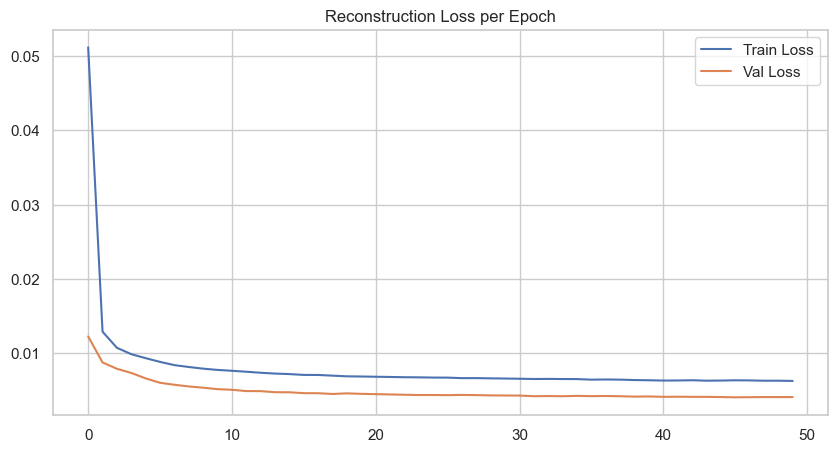

In [17]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Reconstruction Loss per Epoch')
plt.legend()
plt.show()

## 3. Anomaly Detection & thresholding

C:\Users\musab\AppData\Local\Temp\ipykernel_4764\3473568153.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../../results/models/autoen

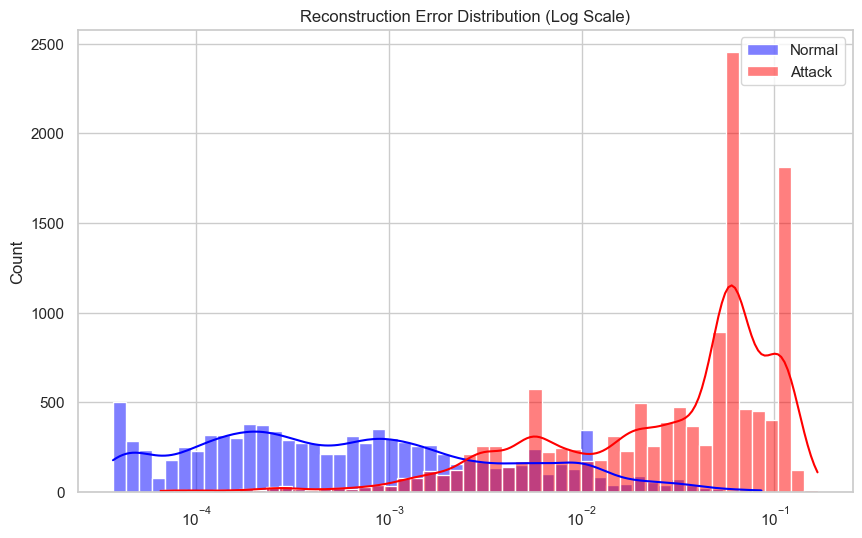

In [18]:
model.load_state_dict(torch.load("../../results/models/autoencoder_nsl_kdd.pt"))
model.eval()

def get_reconstruction_errors(model, X):
    dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X))
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    errors = []
    with torch.no_grad():
        for X_batch, in loader:
            X_batch = X_batch.to(device)
            x_recon, _ = model(X_batch)
            mse = ((x_recon - X_batch) ** 2).mean(dim=1)
            errors.extend(mse.cpu().numpy())
    return np.array(errors)

# Compute errors on Test set
test_errors = get_reconstruction_errors(model, X_test)

# Separate errors by class
errors_normal = test_errors[y_test == 0]
errors_attack = test_errors[y_test == 1]

plt.figure(figsize=(10, 6))
sns.histplot(errors_normal, bins=50, color='blue', alpha=0.5, label='Normal', kde=True, log_scale=True)
sns.histplot(errors_attack, bins=50, color='red', alpha=0.5, label='Attack', kde=True, log_scale=True)
plt.title('Reconstruction Error Distribution (Log Scale)')
plt.legend()
plt.show()

ROC-AUC Score: 0.9404
Selected Threshold (95th percentile of normal data): 0.012448

Classification Report:
              precision    recall  f1-score   support

      Normal       0.73      0.95      0.83      9711
      Attack       0.95      0.74      0.83     12833

    accuracy                           0.83     22544
   macro avg       0.84      0.84      0.83     22544
weighted avg       0.86      0.83      0.83     22544



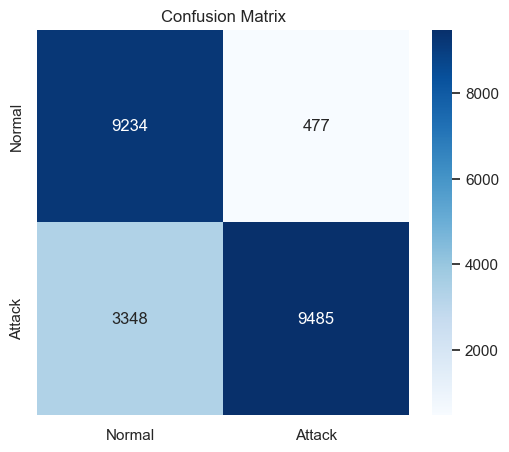

19928

In [19]:
# ROC Curve
roc_auc = roc_auc_score(y_test, test_errors)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Determine threshold
threshold = np.percentile(errors_normal, CONFIG['threshold_percentile'])
print(f"Selected Threshold ({CONFIG['threshold_percentile']}th percentile of normal data): {threshold:.6f}")

# Predictions
y_pred = (test_errors > threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.show()

#Cleanup
torch.cuda.empty_cache()
import gc
gc.collect()